In [1]:
import os
from matplotlib import pyplot as plt
import tensorflow as tf
import tensorflow_io as tfio
import librosa
import soundfile as sf

2023-03-14 14:04:33.751940: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-14 14:04:43.708685: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /grid5000/spack/opt/spack/linux-debian10-x86_64/gcc-8.3.0/cudnn-8.2.4.15-11.4-uwlg4gcvq747ac3tdgpzkle6amp5xlro/lib64
2023-03-14 14:04:43.709125: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /grid5000/spa

# Data Processing

In [28]:
from pydub import AudioSegment
import csv
import re
import numpy as np
import shutil
from pydub import AudioSegment

In [3]:
def convert_flac_to_wav(src_folder, dst_folder):
    # Create destination folder if it doesn't exist
    if not os.path.exists(dst_folder):
        os.makedirs(dst_folder)

    # Loop over all files in the source folder
    for filename in os.listdir(src_folder):
        if filename.endswith('.flac'):
            # Load the audio file using pydub
            filepath = os.path.join(src_folder, filename)
            sound = AudioSegment.from_file(filepath, format='flac')

            # Create the output filename with .wav extension
            output_filename = os.path.splitext(filename)[0] + '.wav'
            output_filepath = os.path.join(dst_folder, output_filename)

            # Export the audio as WAV
            sound.export(output_filepath, format='wav')

In [4]:
#convert_flac_to_wav("data/British birds/", "data/British birds wav/")

In [27]:
def convert_mp3_to_wav(source_folder, dest_folder):
    # Create destination folder if it doesn't exist
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
    
    # Loop through source folder and convert each mp3 to wav
    for filename in os.listdir(source_folder):
        if filename.endswith(".mp3"):
            print("Processing : " + filename)
            mp3_path = os.path.join(source_folder, filename)
            wav_path = os.path.join(dest_folder, os.path.splitext(filename)[0] + ".wav")
            if not os.path.exists(wav_path):
                AudioSegment.from_mp3(mp3_path).export(wav_path, format="wav")
            os.remove(mp3_path)

In [29]:
#convert_mp3_to_wav("data/European mp3/","data/European wav/")

In [5]:
def get_csv_content(filepath):
    # Open the CSV file
    with open(filepath, newline='') as csvfile:
        # Create a CSV reader object
        reader = csv.reader(csvfile, delimiter=',')

        # Create a list to store the contents of the CSV file
        content = []

        # Loop over each row in the CSV file
        for row in reader:
            # Append the row to the content list
            content.append(row)

    # Return the content list
    return content

In [22]:
#Associate the name of the bird to the song
def file_with_name(src_folder_csv, src_folder_song,files_id,species_id):
    csv = get_csv_content(src_folder_csv)
    files = os.listdir(src_folder_song)
    rows = len(csv) - 1
    cols = 2
    dico={}
    i = 0
    for line in csv[1:]:
        for filename in files:
            match = re.search(r'\d+', filename)
            if match:
                number = match.group(0)
                if number == line[files_id]:
                    dico[filename] = line[species_id].lower()
                    files.remove(filename)
                    i += 1
                    break
    return dico
        

In [23]:
bird_file_name_dico = file_with_name("data/European mp3.csv","data/European wav/",0,4)

In [24]:
#Create a folder by species with its wav
def foldersBySpecies(src_folder,dst_folder,dico):
    for filename in os.listdir(src_folder):
        print("Processing : " + filename)
        folder = dico[filename].lower()
        if not os.path.exists(dst_folder+folder):
            os.makedirs(dst_folder+folder)
        folder = os.path.join(dst_folder,folder)
        shutil.copy(src_folder+filename,folder+"/"+filename)
        os.remove(src_folder + filename)
        
    

In [26]:
#foldersBySpecies("data/European wav/","data/species/",bird_file_name_dico)

In [39]:
def merge_folders_with_uppercase_names(src_folder):
    # Create a dictionary to store lowercase folder names as keys and lists of uppercase folder names as values
    folders_dict = {}

    # Loop through the source folder and identify any folders with uppercase names
    for folder in os.listdir(src_folder):
        if folder.lower()!=folder:
            # Convert the folder name to lowercase
            lowercase_folder = folder.lower()

            # If the lowercase folder doesn't exist in the dictionary, add it
            if lowercase_folder not in folders_dict:
                folders_dict[lowercase_folder] = []

            # Add the uppercase folder to the list of folders for the corresponding lowercase folder
            folders_dict[lowercase_folder].append(folder)

    # Loop through the dictionary and merge the contents of each uppercase folder into the corresponding lowercase folder
    for lowercase_folder, uppercase_folders in folders_dict.items():
        for uppercase_folder in uppercase_folders:
            lowercase_path = os.path.join(src_folder, lowercase_folder)
            uppercase_path = os.path.join(src_folder, uppercase_folder)
            if os.path.exists(uppercase_path):
                for filename in os.listdir(uppercase_path):
                    src_file_path = os.path.join(uppercase_path, filename)
                    dst_file_path = os.path.join(lowercase_path, filename)
                    shutil.move(src_file_path, dst_file_path)

            # Remove the empty uppercase folder
            os.rmdir(uppercase_path)

In [40]:
#merge_folders_with_uppercase_names("data/species/")

# DataSet

In [50]:
def count_species(folder):
    if not os.path.isdir(folder):
        raise ValueError(f"{folder} is not a directory")
    return len(os.listdir(folder))

In [83]:
def count_wav_files(folder,extention):
    count = 0
    for item in os.listdir(folder):
        item_path = os.path.join(folder, item)
        if os.path.isdir(item_path):
            count += count_wav_files(item_path,extention)
        elif item.lower().endswith(extention):
            count += 1
    return count

In [84]:
print("Number of species : " + str(count_species('data/species/')))
print("Number of sounds : " + str(count_wav_files('data/species/','.wav')))

Number of species : 136
Number of sounds : 2352


# Data loading

In [41]:
#PATHS
#CAPUCHIN_FILE = os.path.join('data', 'Parsed_Capuchinbird_Clips', 'XC3776-3.wav')
#NOT_CAPUCHIN_FILE = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips', 'afternoon-birds-song-in-forest-0.wav')
BRITISH_FILE = os.path.join('xc64738.wav')#os.path.join('data', 'British birds wav', 'xc71024.wav')

In [42]:
def load_wav_16k_mono(filename):
    size = 16000
    # Load encoded wav file
    file_contents = tf.io.read_file(filename)
    """if tf.equal(tf.strings.length(file_contents), 0):
        return -1"""
    
    try:
        # Decode wav (tensors by channels) 
        #wav, sample_rate = tf.audio.decode_wav(file_contents,desired_channels=1)
        #wav, sample_rate = librosa.load(file_contents, sr=None)
        
        wav, sample_rate = sf.read(filename, dtype='float32')
        wav = wav.reshape(-1, 1)
        
        # Removes trailing axis
        wav = tf.squeeze(wav, axis=-1)
        sample_rate = tf.cast(sample_rate, dtype=tf.int64)

        # Goes from 44100Hz to 16000hz - amplitude of the audio signal
        wav = tfio.audio.resample(wav, rate_in=sample_rate,rate_out=size)

        return wav
    except tf.errors.InvalidArgumentError as e:
        return -1

In [43]:
#plot wave
#wave = load_wav_16k_mono(CAPUCHIN_FILE)
#nwave = load_wav_16k_mono(NOT_CAPUCHIN_FILE)
bwave =  load_wav_16k_mono(BRITISH_FILE)

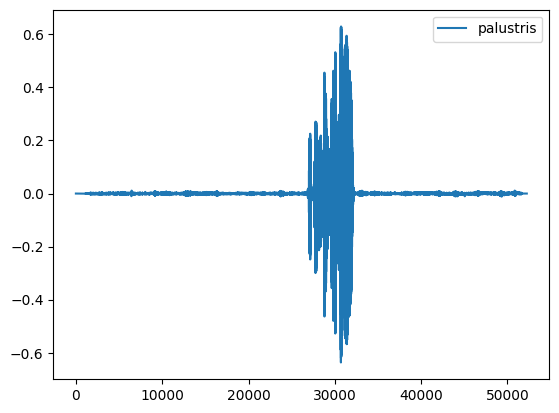

In [44]:
#visualise waves
#plt.plot(wave, label="capuchin")
#plt.plot(nwave, label="other")
plt.plot(bwave, label="palustris")
plt.legend()
plt.show()

# tensorflow dataset

In [45]:
#define paths to positive and negative data
POS = os.path.join('data', 'Parsed_Capuchinbird_Clips')
#NEG = os.path.join('data', 'Parsed_Not_Capuchinbird_Clips')
SPECIES = os.path.join('data', 'species')

SPECIES_DICO={}
for folder in os.listdir(SPECIES):
    SPECIES_DICO[folder] = os.path.join(SPECIES,folder)

In [46]:
#create tensorflow dataset
#pos = tf.data.Dataset.list_files(POS+'\*.wav')
#neg = tf.data.Dataset.list_files(NEG+'\*.wav')
species = {}
for folder in SPECIES_DICO:
    if not SPECIES_DICO[folder].split("/")[-1].startswith('.'):
        species[folder] = tf.data.Dataset.list_files(SPECIES_DICO[folder]+'/*.wav')

In [47]:
### Add labels and combine positive and negative samples
#positives = tf.data.Dataset.zip((pos,tf.data.Dataset.from_tensor_slices(tf.ones(len(pos)))))
#negatives = tf.data.Dataset.zip((neg,tf.data.Dataset.from_tensor_slices(tf.zeros(len(neg)))))    
datasets={}
i=0
for specie in species:
    #tf.zeros(len(species[specie]))
    datasets[specie] = tf.data.Dataset.zip((species[specie],tf.data.Dataset.from_tensor_slices(np.full(len(species[specie]), i))))
    i+=1
   
start = True
for dataset in datasets.values():
    if start:
        data = dataset
        start = False
    else:
        data = data.concatenate(dataset)


#data = positives.concatenate(negatives)
#list(data.as_numpy_iterator())
list(data.as_numpy_iterator())

[(b'data/species/stellata/xc58573.wav', 0),
 (b'data/species/stellata/xc58571.wav', 0),
 (b'data/species/stellata/xc58579.wav', 0),
 (b'data/species/flava/xc36637.wav', 1),
 (b'data/species/flava/xc102788.wav', 1),
 (b'data/species/flava/xc69792.wav', 1),
 (b'data/species/flammea/xc132608.wav', 2),
 (b'data/species/flammea/xc132611.wav', 2),
 (b'data/species/flammea/xc35068.wav', 2),
 (b'data/species/european pied flycatcher/Ficedula-hypoleuca-320012.wav', 3),
 (b'data/species/european pied flycatcher/Ficedula-hypoleuca-314250.wav', 3),
 (b'data/species/european pied flycatcher/Ficedula-hypoleuca-372227.wav', 3),
 (b'data/species/european pied flycatcher/Ficedula-hypoleuca-198837.wav', 3),
 (b'data/species/european pied flycatcher/Ficedula-hypoleuca-420072.wav', 3),
 (b'data/species/european pied flycatcher/Ficedula-hypoleuca-215585.wav', 3),
 (b'data/species/european pied flycatcher/Ficedula-hypoleuca-372226.wav', 3),
 (b'data/species/european pied flycatcher/Ficedula-hypoleuca-134096

# Average length of a Birds

In [48]:
lengths = []
number_of_data = 0
number_of_data_valide = 0
for specie in SPECIES_DICO:
    for file in os.listdir(SPECIES_DICO[specie]):
        number_of_data+=1
        print("Processing on : " + file + " from the folder : " + SPECIES_DICO[specie])
        tensor_wave = load_wav_16k_mono(os.path.join(SPECIES_DICO[specie],file))
        if str(tensor_wave)!="-1":
            number_of_data_valide+=1
            lengths.append(len(tensor_wave))
print("Number of data processed :" + str(number_of_data))
print("Number of data valid :" + str(number_of_data_valide))

Processing on : xc58573.wav from the folder : data/species/stellata
Processing on : xc58579.wav from the folder : data/species/stellata
Processing on : xc58571.wav from the folder : data/species/stellata
Processing on : xc69792.wav from the folder : data/species/flava
Processing on : xc102788.wav from the folder : data/species/flava
Processing on : xc36637.wav from the folder : data/species/flava
Processing on : xc35068.wav from the folder : data/species/flammea
Processing on : xc132608.wav from the folder : data/species/flammea
Processing on : xc132611.wav from the folder : data/species/flammea
Processing on : Ficedula-hypoleuca-474130.wav from the folder : data/species/european pied flycatcher
Processing on : Ficedula-hypoleuca-132583.wav from the folder : data/species/european pied flycatcher
Processing on : Ficedula-hypoleuca-164969.wav from the folder : data/species/european pied flycatcher
Processing on : Ficedula-hypoleuca-372227.wav from the folder : data/species/european pied 

In [49]:
#calculate mean, min and max
print(tf.math.reduce_mean(lengths))
print(tf.math.reduce_min(lengths))
print(tf.math.reduce_max(lengths))

tf.Tensor(2815172, shape=(), dtype=int32)
tf.Tensor(32757, shape=(), dtype=int32)
tf.Tensor(52548895, shape=(), dtype=int32)


# Preprocessing function to convert to spectrogram

In [51]:
def preprocess(file_path,label):
    size = 100000#1073719 #it's the average find above
    wav = load_wav_16k_mono(filepath)
    wav = wav[:size] #we keep the 48000 firsts stape. Choose with the numbers above
    if len(wav)<size:
        zero_padding = tf.zeros([size]- tf.shape(wav), dtype=tf.float32) #Complete with 0 when no enough data as the less is at 32000
        wav = tf.concat([zero_padding,wav],0)
    spectrogram = tf.signal.stft(wav,frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

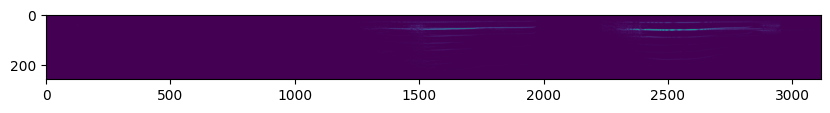

In [52]:
# test and vizualise the spectrogram
"""filepath, label = positives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath,label)

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

filepath, label = negatives.shuffle(buffer_size=10000).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath,label)

plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()"""

filepath, label = data.shuffle(buffer_size=3).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath,label)

plt.figure(figsize=(10,100))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

# Training and Testing Partitions

In [53]:
#Creation of a tensorflow data pipeline

#apply the function preprocess to our data set
data = data.map(preprocess)
data = data.cache()
#to not keep the good in a side and bad in another
data = data.shuffle(buffer_size=1000)

batch = 16
data = data.batch(batch)
data = data.prefetch(8)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [54]:
# split into training and testing partitions
data_len = len(data)
number_train = round(data_len*.7) #70% of the data for train
train = data.take(number_train)
test = data.skip(number_train).take(data_len-number_train)

In [55]:
samples, labels = train.as_numpy_iterator().next()

2023-03-14 15:14:36.885155: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


# Model

In [56]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [57]:
#Sequential Model
model = Sequential()
#16(batch) different cannels of shape 3,3
model.add(Conv2D(batch,(3,3),activation='relu',input_shape=(samples.shape[1],samples.shape[2],samples.shape[3])))
model.add(Conv2D(batch,(3,3),activation='relu'))
model.add(Flatten())
model.add(Dense(16, activation='relu'))
model.add(Dense(1,activation='sigmoid'))

In [58]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 3114, 255, 16)     160       
                                                                 
 conv2d_1 (Conv2D)           (None, 3112, 253, 16)     2320      
                                                                 
 flatten (Flatten)           (None, 12597376)          0         
                                                                 
 dense (Dense)               (None, 16)                201558032 
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 201,560,529
Trainable params: 201,560,529
Non-trainable params: 0
_________________________________________________________________


## fit model

In [88]:
hist = model.fit(train, epochs=3, validation_data=test)

Epoch 1/3
103/103 [==============================] - 22s 215ms/step - loss: -1210702425489408.0000 - recall: 1.0000 - precision: 0.9982 - val_loss: -1747392814645248.0000 - val_recall: 1.0000 - val_precision: 0.9957
Epoch 2/3
103/103 [==============================] - 22s 216ms/step - loss: -1340427215044608.0000 - recall: 1.0000 - precision: 0.9994 - val_loss: -1943938302738432.0000 - val_recall: 1.0000 - val_precision: 1.0000
Epoch 3/3
103/103 [==============================] - 22s 216ms/step - loss: -1487601919852544.0000 - recall: 1.0000 - precision: 0.9982 - val_loss: -2229682879594496.0000 - val_recall: 1.0000 - val_precision: 1.0000


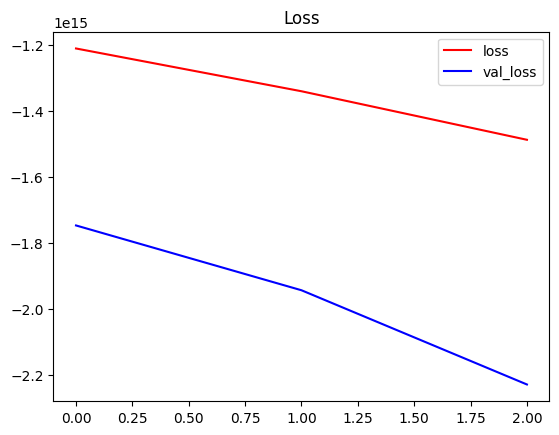

In [89]:
plt.title('Loss')
plt.plot(hist.history['loss'], 'r',label='loss')
plt.plot(hist.history['val_loss'], 'b',label='val_loss')
plt.legend()
plt.show()

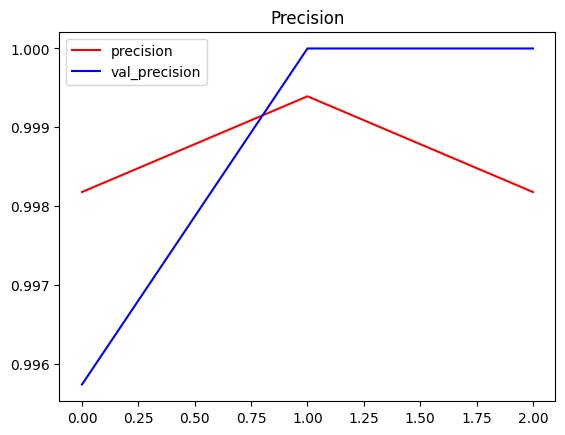

In [90]:
plt.title('Precision')
plt.plot(hist.history['precision'], 'r',label='precision')
plt.plot(hist.history['val_precision'], 'b',label='val_precision')
plt.legend()
plt.show()

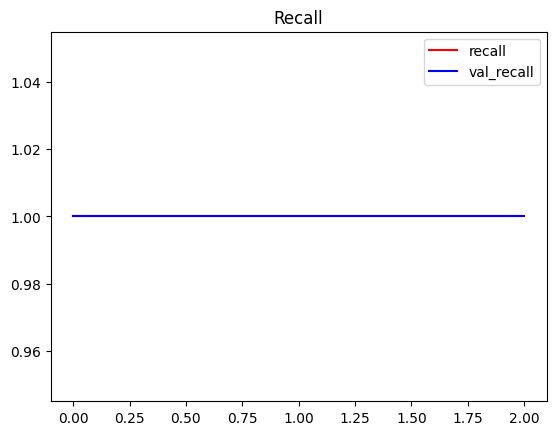

In [91]:
plt.title('Recall')
plt.plot(hist.history['recall'], 'r',label='recall')
plt.plot(hist.history['val_recall'], 'b',label='val_recall')
plt.legend()
plt.show()

# Prediction 

In [45]:
#Get One Batch and Make a Prediction
X_test, y_test = test.as_numpy_iterator().next()
yhat_test = model.predict(X_test)

1/1 [==============================] - 0s 50ms/step


In [46]:
#Convert Logits to Classes
yhat = [1 if prediction > 0.9 else 0 for prediction in yhat_test]
print(yhat_test)

[[1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]
 [1.]]


# Forest parsing

In [ ]:
#load up mp3s
def load_mp3_16k_mono(filename):
    """ Load a WAV file, convert it to a float tensor, resample to 16 kHz single-channel audio. """
    res = tfio.audio.AudioIOTensor(filename)
    # Convert to tensor and combine channels 
    tensor = res.to_tensor()
    tensor = tf.math.reduce_sum(tensor, axis=1) / 2 
    # Extract sample rate and cast
    sample_rate = res.rate
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    # Resample to 16 kHz
    wav = tfio.audio.resample(tensor, rate_in=sample_rate, rate_out=16000)
    return wav

In [ ]:
mp3 = os.path.join('data', 'Forest Recordings', 'recording_00.mp3')

In [ ]:
wav = load_mp3_16k_mono(mp3)

In [ ]:
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)

In [ ]:
samples, index = audio_slices.as_numpy_iterator().next()

In [ ]:
# convert clips into windowed spectrograms
def preprocess_mp3(sample, index):
    sample = sample[0]
    zero_padding = tf.zeros([48000] - tf.shape(sample), dtype=tf.float32)
    wav = tf.concat([zero_padding, sample],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram

In [ ]:
# convert longer clips int windows anad make predictions
audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=16000, sequence_stride=16000, batch_size=1)
audio_slices = audio_slices.map(preprocess_mp3)
audio_slices = audio_slices.batch(64)

In [ ]:
yhat = model.predict(audio_slices)
yhat = [1 if prediction > 0.5 else 0 for prediction in yhat]

In [ ]:
# group consecutive detections
from itertools import groupby

In [ ]:
yhat = [key for key, group in groupby(yhat)]
calls = tf.math.reduce_sum(yhat).numpy()

In [ ]:
calls

# Predictions

In [ ]:
#loop over all recordings and make predictions
results = {}
for file in os.listdir(os.path.join('data', 'Forest Recordings')):
    FILEPATH = os.path.join('data','Forest Recordings', file)
    
    wav = load_mp3_16k_mono(FILEPATH)
    audio_slices = tf.keras.utils.timeseries_dataset_from_array(wav, wav, sequence_length=48000, sequence_stride=48000, batch_size=1)
    audio_slices = audio_slices.map(preprocess_mp3)
    audio_slices = audio_slices.batch(64)
    
    yhat = model.predict(audio_slices)
    
    results[file] = yhat

In [ ]:
results

In [ ]:
#convert predictions into classes
class_preds = {}
for file, logits in results.items():
    class_preds[file] = [1 if prediction > 0.99 else 0 for prediction in logits]
class_preds

In [ ]:
#group consecutive detections 
postprocessed = {}
for file, scores in class_preds.items():
    postprocessed[file] = tf.math.reduce_sum([key for key, group in groupby(scores)]).numpy()
postprocessed

# export results

In [ ]:
import csv

In [ ]:
with open('results.csv', 'w', newline='') as f:
    writer = csv.writer(f, delimiter=',')
    writer.writerow(['recording', 'capuchin_calls'])
    for key, value in postprocessed.items():
        writer.writerow([key, value])